In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN, GRU
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

columns_to_use = ['Open', 'High', 'Low', 'Close']

for col in columns_to_use:
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

train_data.dropna(inplace=True)
test_data.dropna(inplace=True)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(train_data[columns_to_use].values)
scaled_test = scaler.transform(test_data[columns_to_use].values)

N = 60
M = 1

X, y = [], []
for i in range(N, len(scaled_train) - M + 1):
    X.append(scaled_train[i-N:i, :])
    y.append(scaled_train[i:i+M, 0])

X, y = np.array(X), np.array(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
test_full = np.concatenate((scaled_train[-N:], scaled_test), axis=0)

X_test, y_test = [], []
for i in range(N, len(test_full) - M + 1):
    X_test.append(test_full[i-N:i, :])
    y_test.append(test_full[i:i+M, 0])

X_test, y_test = np.array(X_test), np.array(y_test)

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (20, 60, 4)
y_test shape: (20, 1)


In [30]:
def LSTM_model(X_train, y_train, X_val, y_val, units, dropout_rate, batch_size, epochs):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=0)
    val_loss = min(history.history['val_loss'])
    return model, val_loss

param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [16, 32],
    'epochs': [50],
}

best_model = None
best_val_loss = float('inf')
best_params = {}

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                print(f"Training with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
                model, val_loss = LSTM_model(X_train, y_train, X_val, y_val, units, dropout_rate, batch_size, epochs)
                print(f"Validation Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'epochs': epochs,
                    }

print(f"Best Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")

Training with units=50, dropout_rate=0.2, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.0004944787942804396
Training with units=50, dropout_rate=0.2, batch_size=32, epochs=50
Validation Loss: 0.0006439885473810136
Training with units=50, dropout_rate=0.3, batch_size=16, epochs=50
Validation Loss: 0.0005220302846282721
Training with units=50, dropout_rate=0.3, batch_size=32, epochs=50
Validation Loss: 0.0006400264683179557
Training with units=100, dropout_rate=0.2, batch_size=16, epochs=50
Validation Loss: 0.0003713169426191598
Training with units=100, dropout_rate=0.2, batch_size=32, epochs=50
Validation Loss: 0.00051719113253057
Training with units=100, dropout_rate=0.3, batch_size=16, epochs=50
Validation Loss: 0.0004253252118360251
Training with units=100, dropout_rate=0.3, batch_size=32, epochs=50
Validation Loss: 0.0005406614509411156
Best Parameters: {'units': 100, 'dropout_rate': 0.2, 'batch_size': 16, 'epochs': 50}
Best Validation Loss: 0.0003713169426191598


In [31]:
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

final_model = Sequential()
final_model.add(LSTM(units=best_params['units'], return_sequences=True, input_shape=(X_combined.shape[1], X_combined.shape[2])))
final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(LSTM(units=best_params['units'], return_sequences=False))
final_model.add(Dropout(best_params['dropout_rate']))
final_model.add(Dense(units=1))
final_model.compile(optimizer='adam', loss='mean_squared_error')

final_model.fit(X_combined, y_combined, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.0407
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.0044
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0037
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.0028
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 0.0030
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - loss: 0.0054
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0033
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.0025
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0027
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.0030
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - loss: 0.0023
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0031
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.0021
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 0.0021
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0025
Epoc

In [32]:
predicted_stock_price = final_model.predict(X_test)

predicted_stock_price_rescaled = scaler.inverse_transform(
    np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], X_test.shape[2] - 1))))
)[:, 0]

real_stock_price_rescaled = scaler.inverse_transform(
    np.hstack((y_test, np.zeros((y_test.shape[0], X_test.shape[2] - 1))))
)[:, 0]

mae = mean_absolute_error(real_stock_price_rescaled, predicted_stock_price_rescaled)
mse = mean_squared_error(real_stock_price_rescaled, predicted_stock_price_rescaled)

print(f"Final Model Mean Absolute Error: {mae}")
print(f"Final Model Mean Squared Error: {mse}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Final Model Mean Absolute Error: 12.17946413600447
Final Model Mean Squared Error: 178.99374820965463


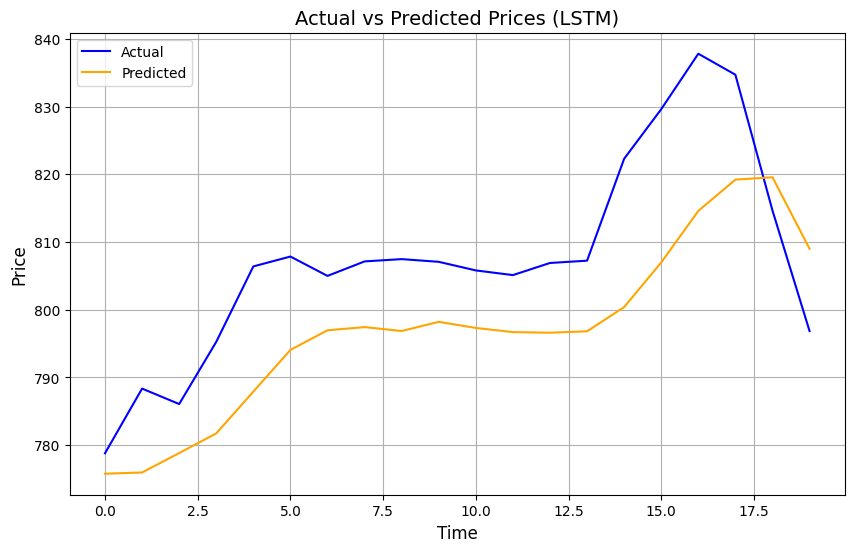

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price_rescaled, color='blue', label='Actual')
plt.plot(predicted_stock_price_rescaled, color='orange', label='Predicted')
plt.title('Actual vs Predicted Prices (LSTM)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [34]:
def vanilla_rnn_model(X_train, y_train, X_val, y_val, units, dropout_rate, batch_size, epochs):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    val_loss = min(history.history['val_loss'])  # Get the minimum validation loss
    return model, val_loss


In [35]:
param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [16, 32, 64],
    'epochs': [50],
}

best_model = None
best_val_loss = float('inf')
best_params = {}

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                print(f"Training Vanilla RNN with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
                model, val_loss = vanilla_rnn_model(X_train, y_train, X_val, y_val, units, dropout_rate, batch_size, epochs)
                print(f"Validation Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'epochs': epochs,
                    }

print(f"Best Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")

Training Vanilla RNN with units=50, dropout_rate=0.2, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.00031008454971015453
Training Vanilla RNN with units=50, dropout_rate=0.2, batch_size=32, epochs=50
Validation Loss: 0.0003230499860364944
Training Vanilla RNN with units=50, dropout_rate=0.2, batch_size=64, epochs=50
Validation Loss: 0.00038085452979430556
Training Vanilla RNN with units=50, dropout_rate=0.3, batch_size=16, epochs=50
Validation Loss: 0.00044008728582412004
Training Vanilla RNN with units=50, dropout_rate=0.3, batch_size=32, epochs=50
Validation Loss: 0.0004243477596901357
Training Vanilla RNN with units=50, dropout_rate=0.3, batch_size=64, epochs=50
Validation Loss: 0.0004596775397658348
Training Vanilla RNN with units=50, dropout_rate=0.4, batch_size=16, epochs=50
Validation Loss: 0.0005523376166820526
Training Vanilla RNN with units=50, dropout_rate=0.4, batch_size=32, epochs=50
Validation Loss: 0.0005922951968386769
Training Vanilla RNN with units=50, dropout_rate=0.4, batch_size=64, epochs=50
Validation Loss: 0.0005977866239845753
Training Vanil

In [36]:
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

final_rnn_model = Sequential()
final_rnn_model.add(SimpleRNN(units=best_params['units'], return_sequences=True, input_shape=(X_combined.shape[1], X_combined.shape[2])))
final_rnn_model.add(Dropout(best_params['dropout_rate']))
final_rnn_model.add(SimpleRNN(units=best_params['units'], return_sequences=False))
final_rnn_model.add(Dropout(best_params['dropout_rate']))
final_rnn_model.add(Dense(units=1))

final_rnn_model.compile(optimizer='adam', loss='mean_squared_error')

final_rnn_model.fit(X_combined, y_combined, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

predicted_stock_price = final_rnn_model.predict(X_test)

predicted_stock_price_rescaled = scaler.inverse_transform(
    np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], X_test.shape[2] - 1))))
)[:, 0]

real_stock_price_rescaled = scaler.inverse_transform(
    np.hstack((y_test, np.zeros((y_test.shape[0], X_test.shape[2] - 1))))
)[:, 0]

mae = mean_absolute_error(real_stock_price_rescaled, predicted_stock_price_rescaled)
mse = mean_squared_error(real_stock_price_rescaled, predicted_stock_price_rescaled)
print(f"Final Vanilla RNN Mean Absolute Error: {mae}")
print(f"Final Vanilla RNN Mean Squared Error: {mse}")

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 0.3821
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1667
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0621
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0361
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0234
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0206
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0153
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0111
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0132
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0096
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0114
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0073
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0069
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0059
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0060
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step
Final Vanilla RNN Mean Absolute Error: 10.975224443912504
Final Vanilla RNN Mean Squared Error: 138.9733681561974


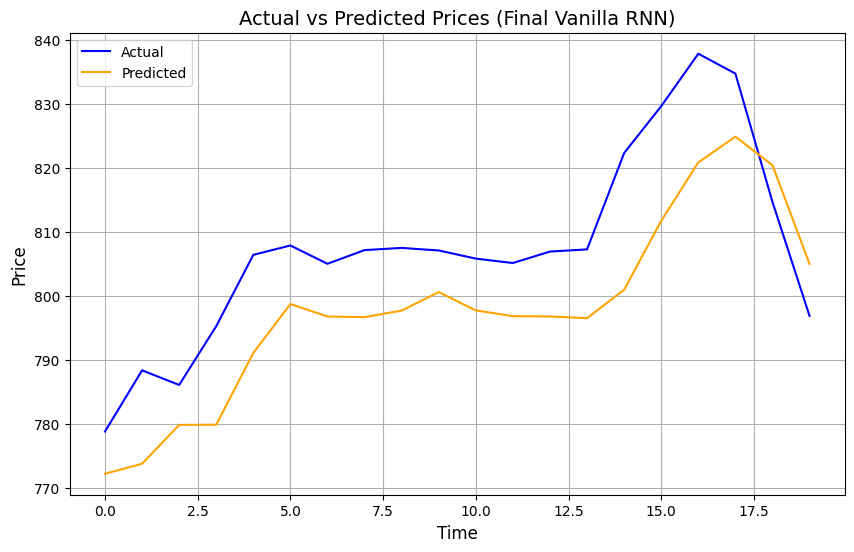

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price_rescaled, color='blue', label='Actual')
plt.plot(predicted_stock_price_rescaled, color='orange', label='Predicted')
plt.title('Actual vs Predicted Prices (Final Vanilla RNN)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [38]:
def gru_model(X_train, y_train, X_val, y_val, units, dropout_rate, batch_size, epochs):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )

    val_loss = min(history.history['val_loss'])
    return model, val_loss


In [39]:
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2, 0.3],
    'batch_size': [16, 32],
    'epochs': [50],
}

best_model = None
best_val_loss = float('inf')
best_params = {}

for units in param_grid['units']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:
            for epochs in param_grid['epochs']:
                print(f"Training GRU with units={units}, dropout_rate={dropout_rate}, batch_size={batch_size}, epochs={epochs}")
                model, val_loss = gru_model(X_train, y_train, X_val, y_val, units, dropout_rate, batch_size, epochs)
                print(f"Validation Loss: {val_loss}")

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model = model
                    best_params = {
                        'units': units,
                        'dropout_rate': dropout_rate,
                        'batch_size': batch_size,
                        'epochs': epochs,
                    }

print(f"Best Parameters: {best_params}")
print(f"Best Validation Loss: {best_val_loss}")

Training GRU with units=50, dropout_rate=0.2, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation Loss: 0.00033453814103268087
Training GRU with units=50, dropout_rate=0.2, batch_size=32, epochs=50
Validation Loss: 0.0003820637648459524
Training GRU with units=50, dropout_rate=0.3, batch_size=16, epochs=50
Validation Loss: 0.0003359751426614821
Training GRU with units=50, dropout_rate=0.3, batch_size=32, epochs=50
Validation Loss: 0.00041971312020905316
Training GRU with units=100, dropout_rate=0.2, batch_size=16, epochs=50
Validation Loss: 0.0002428238367429003
Training GRU with units=100, dropout_rate=0.2, batch_size=32, epochs=50
Validation Loss: 0.00029880733927711844
Training GRU with units=100, dropout_rate=0.3, batch_size=16, epochs=50
Validation Loss: 0.00025516128516756
Training GRU with units=100, dropout_rate=0.3, batch_size=32, epochs=50
Validation Loss: 0.00033559781149961054
Best Parameters: {'units': 100, 'dropout_rate': 0.2, 'batch_size': 16, 'epochs': 50}
Best Validation Loss: 0.0002428238367429003


In [40]:
X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

final_gru_model = Sequential()
final_gru_model.add(GRU(units=best_params['units'], return_sequences=True, input_shape=(X_combined.shape[1], X_combined.shape[2])))
final_gru_model.add(Dropout(best_params['dropout_rate']))
final_gru_model.add(GRU(units=best_params['units'], return_sequences=False))
final_gru_model.add(Dropout(best_params['dropout_rate']))
final_gru_model.add(Dense(units=1))

final_gru_model.compile(optimizer='adam', loss='mean_squared_error')

final_gru_model.fit(X_combined, y_combined, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1)

predicted_stock_price = final_gru_model.predict(X_test)

predicted_stock_price_rescaled = scaler.inverse_transform(
    np.hstack((predicted_stock_price, np.zeros((predicted_stock_price.shape[0], X_test.shape[2] - 1))))
)[:, 0]

real_stock_price_rescaled = scaler.inverse_transform(
    np.hstack((y_test, np.zeros((y_test.shape[0], X_test.shape[2] - 1))))
)[:, 0]

mae = mean_absolute_error(real_stock_price_rescaled, predicted_stock_price_rescaled)
mse = mean_squared_error(real_stock_price_rescaled, predicted_stock_price_rescaled)
print(f"Final GRU Mean Absolute Error: {mae}")
print(f"Final GRU Mean Squared Error: {mse}")

Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - loss: 0.0623
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0037
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0031
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.0026
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - loss: 0.0026
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - loss: 0.0024
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0020
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - loss: 0.0021
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0020
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - loss: 0.0016
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - loss: 0.0036
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.0019
Epoch 13/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0019
Epoch 14/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - loss: 0.0024
Epoch 15/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.

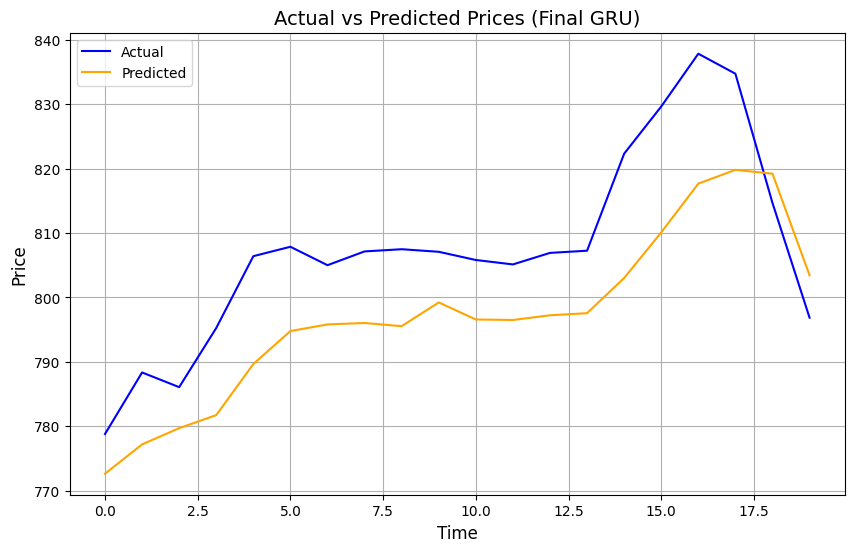

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(real_stock_price_rescaled, color='blue', label='Actual')
plt.plot(predicted_stock_price_rescaled, color='orange', label='Predicted')
plt.title('Actual vs Predicted Prices (Final GRU)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()
